In [1]:
from ROOT import TH1D, TCanvas, TF1, std
from pyLCIO import EVENT, UTIL, IOIMPL, IMPL
#from UTIL import CellIDDecoder
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.colors import LogNorm
import awkward

Welcome to JupyROOT 6.22/00
Loading LCIO ROOT dictionaries ...


In [2]:
import math
import sys
import string


class CellIDDecoder:

    """ decoder for LCIO cellIDs """

    def __init__(self,encStr):
        self.encStr=encStr
        self.funs = {} 

        tokens = encStr.split(',')
        
        offset = 0
        
        for t in tokens:
        
         # print "token: " , t
        
          st = t.split(':')
        
          if len(st)==2:
            name = st[0]
            start = offset 
            width = int(st[1])
            offset += abs( width )
        
          elif len(st)==3:
            name = st[0]
            start = int(st[1]) 
            width = int(st[2])
            offset = start + abs( width )
        
        
          else:
            print ("unknown token:" , t)
        
          mask = int(0x0)
          for i in range(0,abs(width)):
            mask = mask | ( 0x1 << ( i + start) )
        
          setattr( CellIDDecoder , name , self.makefun( mask, start , width) )


    def makefun(self, mask,start,width):
      if( width > 0 ):
        return ( lambda ignore, cellID : (( mask & cellID) >> start )  )
      else:
        return ( lambda ignore, cellID : (~(( mask & cellID) >> start )  ^ 0xffffffff) )

In [ ]:
def Elayer(fName, maxEvt, collection):
    reader = IOIMPL.LCFactory.getInstance().createLCReader()
    reader.open( fName )
    
    
    nEvt = 0

    for evt in reader:
        nEvt += 1
        if nEvt > maxEvt:
                break
        ecalBarrel = evt.getCollection(collection)
    
        cellIDString = ecalBarrel.getParameters().getStringVal("CellIDEncoding")
        decoder = CellIDDecoder( cellIDString ) 
        print (cellIDString)
        for hit in ecalBarrel:
            l = decoder.layer( hit.getCellID0() ) 
            e = hit.getEnergy() 
            p = hit.getPosition()
            print (l,e, p[0], p[1], p[2])   
    
    


In [4]:
def hpfo(fName, maxEvt, collection):
    reader = IOIMPL.LCFactory.getInstance().createLCReader()
    reader.open( fName )
    
    nEvt = 0
    
    x = []
    z = []
    e = []
            
    for evt in reader:
        nEvt += 1
        if nEvt > maxEvt:
                break
        
        col = evt.getCollection(collection)
        cellIDString = "system:0:5,module:5:3,stave:8:4,tower:12:4,layer:16:6,wafer:22:6,slice:28:4,cellX:32:-16,cellY:48:-16"
        decoder = CellIDDecoder( cellIDString ) 
        
        for c in col:
            hits = c.getCalorimeterHits()
            hlistx = []
            hlistz = []
            hliste = []
            for h in hits:
                #print (h.getEnergy(), decoder.layer(h.getCellID0()))
                hlistx.append(h.getPosition()[0])
                hlistz.append(h.getPosition()[2])
                hliste.append(h.getEnergy())
                
        x.append(hlistx)
        z.append(hlistz)
        e.append(hliste)
        
    ## convert to numpy arrays
    
    
    return x,z,e

In [3]:
def hsim(fName, maxEvt, collection):
    reader = IOIMPL.LCFactory.getInstance().createLCReader()
    reader.open( fName )
    
    x = []
    z = []
    e = []

    nEvt = 0

    for evt in reader:
        nEvt += 1
        if nEvt > maxEvt:
                break
        ecalBarrel = evt.getCollection(collection)
        
        hlistx = []
        hlistz = []
        hliste = []
            
        cellIDString = ecalBarrel.getParameters().getStringVal("CellIDEncoding")
        
        for h in ecalBarrel:
            hlistx.append(h.getPosition()[0])
            hlistz.append(h.getPosition()[2])
            hliste.append(h.getEnergy())
            
           
        x.append(hlistx)
        z.append(hlistz)
        e.append(hliste)
        
        
        
    
    
    
    return x,z,e

### SIM 

In [5]:
bib_sim_x, bib_sim_z, bib_sim_e = hsim("v02-02/bibae_REC.slcio", 1000, "EcalBarrelCollection" )
g4_sim_x, g4_sim_z, g4_sim_e = hsim("nom50GeV_noHCALPFO_REC.slcio", 1000, "EcalBarrelCollection" )
vgan_sim_x, vgan_sim_z, vgan_sim_e = hsim("v02-02/vgan_REC.slcio", 1000, "EcalBarrelCollection" )
wgan_sim_x, wgan_sim_z, wgan_sim_e = hsim("v02-02/wgan_REC.slcio", 1000, "EcalBarrelCollection" )

In [6]:
g4simX = awkward.JaggedArray.fromiter(g4_sim_x)
g4simZ = awkward.JaggedArray.fromiter(g4_sim_z)
g4simE = awkward.JaggedArray.fromiter(g4_sim_e)

wgan_simX = awkward.JaggedArray.fromiter(wgan_sim_x)
wgan_simZ = awkward.JaggedArray.fromiter(wgan_sim_z)
wgan_simE = awkward.JaggedArray.fromiter(wgan_sim_e)

vgan_simX = awkward.JaggedArray.fromiter(vgan_sim_x)
vgan_simZ = awkward.JaggedArray.fromiter(vgan_sim_z)
vgan_simE = awkward.JaggedArray.fromiter(vgan_sim_e)

bib_simX = awkward.JaggedArray.fromiter(bib_sim_x)
bib_simZ = awkward.JaggedArray.fromiter(bib_sim_z)
bib_simE = awkward.JaggedArray.fromiter(bib_sim_e)

### Digi 

In [7]:
bib_reco_x, bib_reco_z, bib_reco_e = hsim("v02-02/bibae_REC.slcio", 1000, "EcalBarrelCollectionRec" )
g4_reco_x, g4_reco_z, g4_reco_e = hsim("nom50GeV_noHCALPFO_REC.slcio", 1000, "EcalBarrelCollectionRec" )
vgan_reco_x, vgan_reco_z, vgan_reco_e = hsim("v02-02/vgan_REC.slcio", 1000, "EcalBarrelCollectionRec" )
wgan_reco_x, wgan_reco_z, wgan_reco_e = hsim("v02-02/wgan_REC.slcio", 1000, "EcalBarrelCollectionRec" )


In [8]:
g4recoX = awkward.JaggedArray.fromiter(g4_reco_x)
g4recoZ = awkward.JaggedArray.fromiter(g4_reco_z)
g4recoE = awkward.JaggedArray.fromiter(g4_reco_e)

wgan_recoX = awkward.JaggedArray.fromiter(wgan_reco_x)
wgan_recoZ = awkward.JaggedArray.fromiter(wgan_reco_z)
wgan_recoE = awkward.JaggedArray.fromiter(wgan_reco_e)

vgan_recoX = awkward.JaggedArray.fromiter(vgan_reco_x)
vgan_recoZ = awkward.JaggedArray.fromiter(vgan_reco_z)
vgan_recoE = awkward.JaggedArray.fromiter(vgan_reco_e)

bib_recoX = awkward.JaggedArray.fromiter(bib_reco_x)
bib_recoZ = awkward.JaggedArray.fromiter(bib_reco_z)
bib_recoE = awkward.JaggedArray.fromiter(bib_reco_e)


### Pandora PFOs

In [10]:
g4_pfo_x, g4_pfo_z,g4_pfo_e = hpfo("nom50GeV_noHCALPFO_REC.slcio", 1000, "PandoraClusters" )
bib_pfo_x, bib_pfo_z, bib_pfo_e = hpfo("v02-02/bibae_REC.slcio", 1000, "PandoraClusters" )
vgan_pfo_x,vgan_pfo_z, vgan_pfo_e = hpfo("v02-02/vgan_REC.slcio", 1000, "PandoraClusters" )
wgan_pfo_x,wgan_pfo_z,wgan_pfo_e = hpfo("v02-02/wgan_REC.slcio", 1000, "PandoraClusters" )

In [11]:
g4pfoX = awkward.JaggedArray.fromiter(g4_pfo_x)
g4pfoZ = awkward.JaggedArray.fromiter(g4_pfo_z)
g4pfoE = awkward.JaggedArray.fromiter(g4_pfo_e)

wgan_pfoX = awkward.JaggedArray.fromiter(wgan_pfo_x)
wgan_pfoZ = awkward.JaggedArray.fromiter(wgan_pfo_z)
wgan_pfoE = awkward.JaggedArray.fromiter(wgan_pfo_e)

vgan_pfoX = awkward.JaggedArray.fromiter(vgan_pfo_x)
vgan_pfoZ = awkward.JaggedArray.fromiter(vgan_pfo_z)
vgan_pfoE = awkward.JaggedArray.fromiter(vgan_pfo_e)

bib_pfoX = awkward.JaggedArray.fromiter(bib_pfo_x)
bib_pfoZ = awkward.JaggedArray.fromiter(bib_pfo_z)
bib_pfoE = awkward.JaggedArray.fromiter(bib_pfo_e)


In [181]:
g4pfoX[0].shape

(854,)

In [68]:
a = g4pfoX.flatten().min()

In [69]:
a

-306.90985107421875

In [61]:
Z = np.reshape(g4pfoZ, (1000,1))

In [56]:
XZ = np.concatenate((np.reshape(g4pfoX, (1000,1)), np.reshape(g4pfoZ, (1000,1))), axis=1)
#XZ = np.concatenate([g4pfoX.flatten(), g4pfoZ.flatten()], axis=0)

### plot with imshow 

TypeError: Image data of dtype object cannot be converted to float

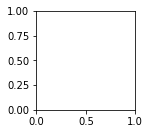

In [31]:
#fig, axs = plt.subplots(1, 2, figsize=(20, 15))
#binX = np.arange(-81, 82, 5.088333)
binX = np.arange(-75.911, 71.65, 5.088333)
binZ = np.arange(-77, 78, 5.088333)



## PFO
plt.subplot(211)
plt.imshow(XZ, cmap=plt.cm.BuPu_r )
#axs[0].set_title("G4 PFO")

#plt.imshow(bib_pfoX.flatten(), bib_pfoZ.flatten())
#axs[0].set_title("Bib-AE PFO")


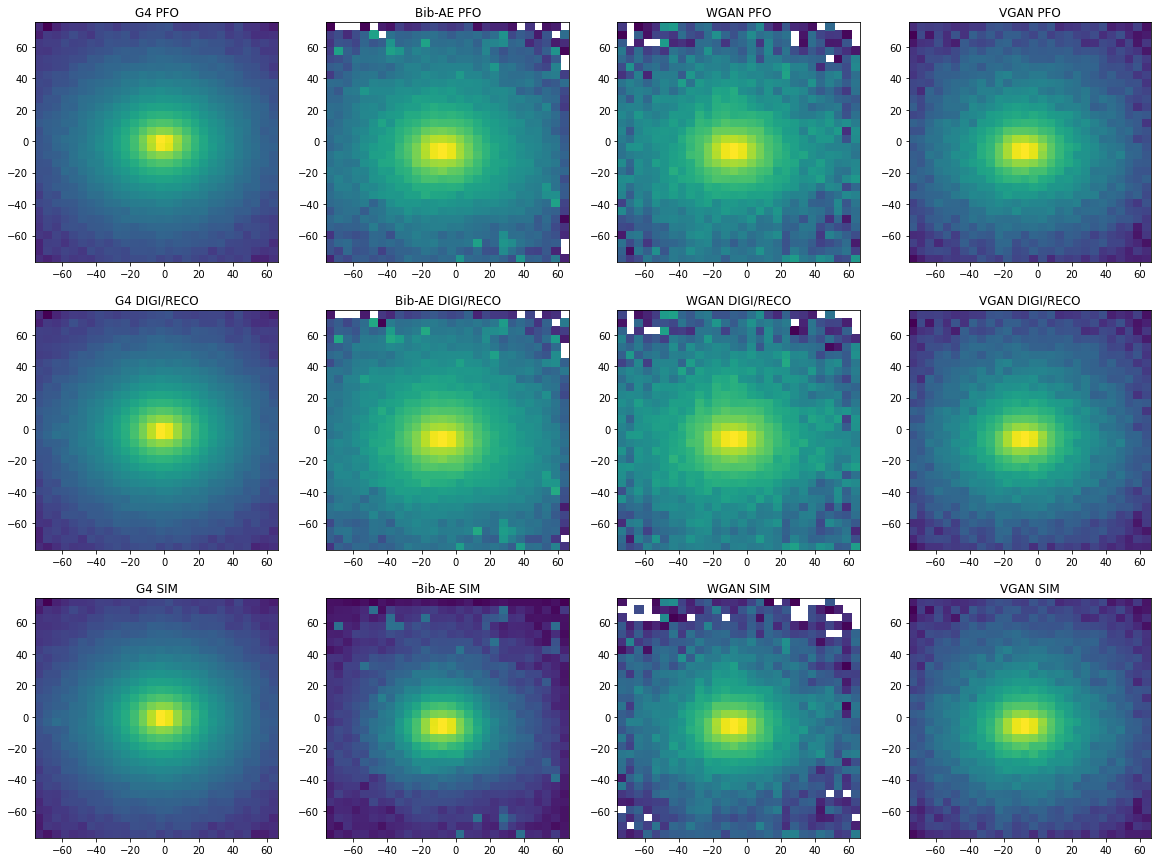

In [89]:
fig, axs = plt.subplots(3, 4, figsize=(20, 15))
#binX = np.arange(-81, 82, 5.088333)
binX = np.arange(-75.911, 71.65, 5.088333)
binZ = np.arange(-77, 78, 5.088333)

cMin=0.001

## PFO
axs[0][0].hist2d(g4pfoX.flatten(), g4pfoZ.flatten(), bins=[binX, binZ], cmin = cMin, cmax=7000, weights=g4pfoE.flatten(), norm=LogNorm())
axs[0][0].set_title("G4 PFO")

axs[0][1].hist2d(bib_pfoX.flatten(), bib_pfoZ.flatten(), bins=[binX, binZ], cmin = cMin, cmax=7000, weights=bib_pfoE.flatten(), norm=LogNorm())
axs[0][1].set_title("Bib-AE PFO")


axs[0][2].hist2d(wgan_pfoX.flatten(), wgan_pfoZ.flatten(), bins=[binX, binZ], cmin = cMin, cmax=7000, weights=wgan_pfoE.flatten(), norm=LogNorm())
axs[0][2].set_title("WGAN PFO")


axs[0][3].hist2d(vgan_pfoX.flatten(), vgan_pfoZ.flatten(), bins=[binX, binZ], cmin = cMin, cmax=7000,weights=vgan_pfoE.flatten(), norm=LogNorm())
axs[0][3].set_title("VGAN PFO")


#### DIGI / RECO
axs[1][0].hist2d(g4recoX.flatten(), g4recoZ.flatten(), bins=[binX, binZ], cmin = cMin, cmax=7000, weights=g4recoE.flatten(), norm=LogNorm())
axs[1][0].set_title("G4 DIGI/RECO")

axs[1][1].hist2d(bib_recoX.flatten(), bib_recoZ.flatten(), bins=[binX, binZ], cmin = cMin, cmax=7000, weights=bib_recoE.flatten(), norm=LogNorm())
axs[1][1].set_title("Bib-AE DIGI/RECO")

axs[1][2].hist2d(wgan_recoX.flatten(), wgan_recoZ.flatten(), bins=[binX, binZ], cmin = cMin, cmax=7000, weights=wgan_recoE.flatten(), norm=LogNorm())
axs[1][2].set_title("WGAN DIGI/RECO")

axs[1][3].hist2d(vgan_recoX.flatten(), vgan_recoZ.flatten(), bins=[binX, binZ], cmin = cMin, cmax=7000, weights=vgan_recoE.flatten(), norm=LogNorm())
axs[1][3].set_title("VGAN DIGI/RECO")

#### SIM
axs[2][0].hist2d(g4simX.flatten(), g4simZ.flatten(), bins=[binX, binZ], cmin = cMin, cmax=7000, weights=g4simE.flatten(), norm=LogNorm())
axs[2][0].set_title("G4 SIM")

axs[2][1].hist2d(bib_simX.flatten(), bib_simZ.flatten(), bins=[binX, binZ], cmin = cMin, cmax=7000, weights=bib_simE.flatten(), norm=LogNorm())
axs[2][1].set_title("Bib-AE SIM")

axs[2][2].hist2d(wgan_simX.flatten(), wgan_simZ.flatten(), bins=[binX, binZ], cmin = cMin, cmax=7000, weights=wgan_simE.flatten(), norm=LogNorm())
axs[2][2].set_title("WGAN SIM")


axs[2][3].hist2d(vgan_simX.flatten(), vgan_simZ.flatten(), bins=[binX, binZ], cmin = cMin, cmax=7000, weights=vgan_simE.flatten(), norm=LogNorm())
axs[2][3].set_title("VGAN SIM")

#plt.colorbar()
plt.show()

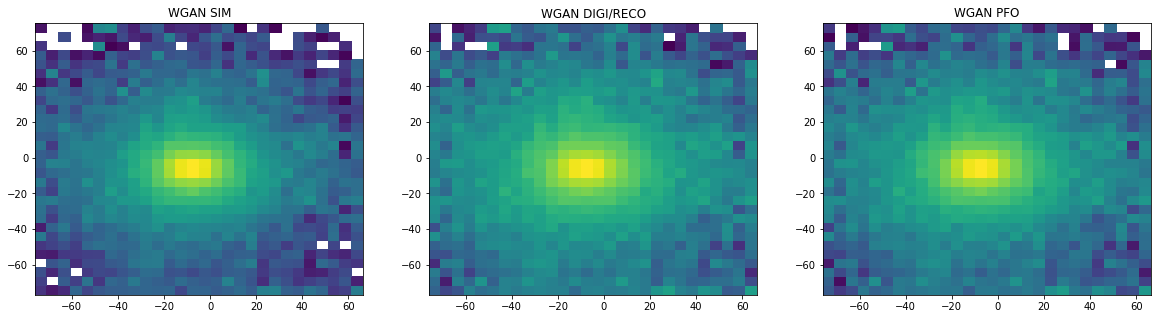

In [93]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
#binX = np.arange(-81, 82, 5.088333)
binX = np.arange(-75.911, 71.65, 5.088333)
binZ = np.arange(-77, 78, 5.088333)

cMin=0.001

## WGAN 

axs[0].hist2d(wgan_simX.flatten(), wgan_simZ.flatten(), bins=[binX, binZ], cmin = cMin, cmax=7000, weights=wgan_simE.flatten(), norm=LogNorm())
axs[0].set_title("WGAN SIM")

axs[1].hist2d(wgan_recoX.flatten(), wgan_recoZ.flatten(), bins=[binX, binZ], cmin = cMin, cmax=7000, weights=wgan_recoE.flatten(), norm=LogNorm())
axs[1].set_title("WGAN DIGI/RECO")

axs[2].hist2d(wgan_pfoX.flatten(), wgan_pfoZ.flatten(), bins=[binX, binZ], cmin = cMin, cmax=7000, weights=wgan_pfoE.flatten(), norm=LogNorm())
axs[2].set_title("WGAN PFO")


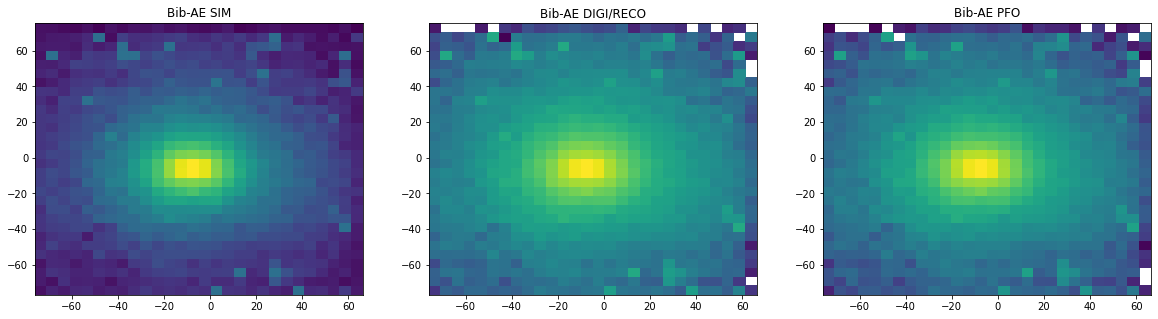

In [105]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
#binX = np.arange(-81, 82, 5.088333)
binX = np.arange(-75.911, 71.65, 5.088333)
binZ = np.arange(-77, 78, 5.088333)

### Bib-AE

axs[0].hist2d(bib_simX.flatten(), bib_simZ.flatten(), bins=[binX, binZ], cmin = cMin, cmax=7000, weights=bib_simE.flatten(), norm=LogNorm())
axs[0].set_title("Bib-AE SIM")

axs[1].hist2d(bib_recoX.flatten(), bib_recoZ.flatten(), bins=[binX, binZ], cmin = cMin, cmax=7000, weights=bib_recoE.flatten(), norm=LogNorm())
axs[1].set_title("Bib-AE DIGI/RECO")

axs[2].hist2d(bib_pfoX.flatten(), bib_pfoZ.flatten(), bins=[binX, binZ], cmin = cMin, cmax=7000, weights=bib_pfoE.flatten(), norm=LogNorm())
axs[2].set_title("Bib-AE PFO")

#plt.colorbar()
plt.show()

In [12]:
def test_hist_2d(x_data, y_data, e_data, titles):
    nrows, ncols = 2, 2
    fig, axes = plt.subplots(nrows, ncols, figsize=(15,15))
    binX = np.arange(-75.911, 71.65, 5.088333)
    binZ = np.arange(-77, 78, 5.088333)


    ##produce the actual data and compute the histograms
    mappables=[]
    for (i,j), ax in np.ndenumerate(axes):
        #print (i,ax)
        H, xedges, yedges = np.histogram2d(x_data[i][j], y_data[i][j], bins=[binX, binZ], weights=e_data[i][j], range=[[-100, 100],[-100, 100]])
        #H, xedges, yedges = plt.hist2d(x_data[i][j], y_data[i][j], bins=[binX, binZ], weights=e_data[i][j], norm=LogNorm())
        ax.set_title(titles[i][j], fontsize=16)
        #ax.set_xlabel(x_labels[i][j])
        #ax.set_ylabel(y_labels[i][j])
        ax.set_aspect("equal")
        mappables.append(H)

    ##the min and max values of all histograms
    vmin = np.min(mappables)
    vmax = np.max(mappables)

    ##second loop for visualisation
    for ax, H in zip(axes.ravel(), mappables):
        im = ax.imshow(H,norm=LogNorm(0.01, vmax), extent=[-80,80,-80,80])
    
    ##colorbar using solution from linked question
    fig.colorbar(im,ax=axes.ravel())
    plt.show()
#    plt.tight_layout
#    plt.tight_layout(pad=i, w_pad=0, h_pad=0)

In [20]:
i=np.random.randint(1,1000)

data_x = [[bib_simX.flatten(), bib_recoX.flatten()], [bib_pfoX.flatten(), bib_pfoX[i].flatten()]]
data_y = [[bib_simZ.flatten(), bib_recoZ.flatten()],  [bib_pfoZ.flatten(), bib_pfoZ[i].flatten()]]
data_e = [[bib_simE.flatten(), bib_recoE.flatten()], [bib_pfoE.flatten(), bib_pfoE[i].flatten()]]

titles = [["SIM", "DIGI/Calib"], ["PFO", "Single image PFO "]] 

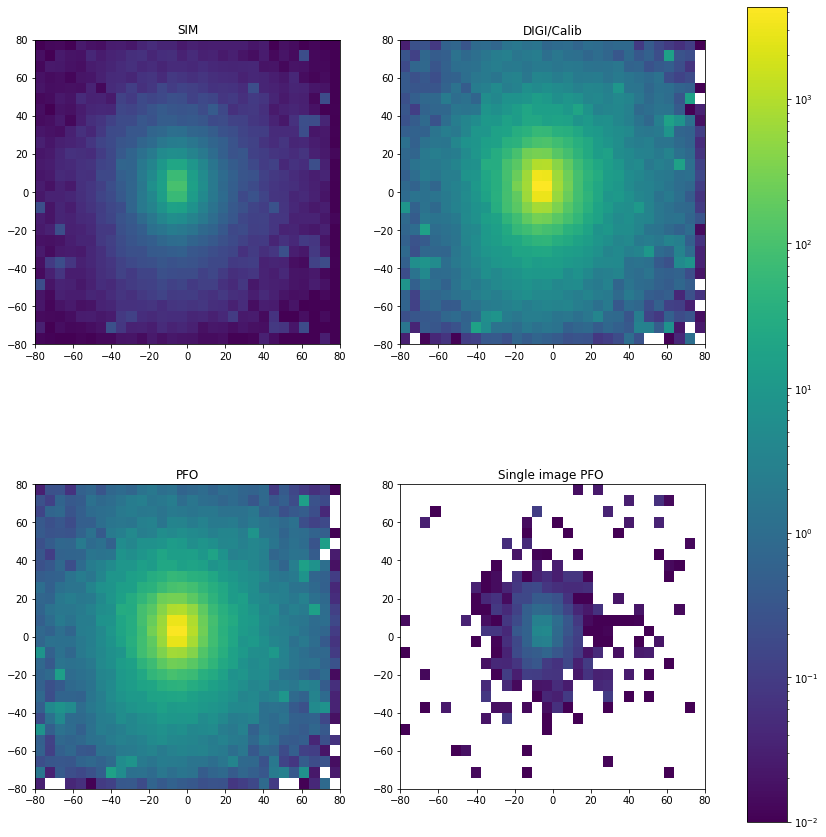

In [21]:
test_hist_2d(data_x, data_y, data_e, titles)